## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Подготовка

In [1]:
import os
import time
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error as mse

from lightgbm import LGBMRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})

# условный путь до директории
PATH = "/datasets/"
# путь к файлу в облаке
URL = {
    0: "https://code.s3.yandex.net/datasets/taxi.csv",
}


def create_df():
    """
    Функция возвращает DataFrame
    если файл не найден по пути в условной переменной PATH, то
    данные будут загруженны из сети. Путь в переменной URL.
    
    os.path.join()
    pd.read_csv()
    """
    try: 
        _ = os.path.join(PATH, "taxi.csv")
        df = pd.read_csv(_, index_col=[0], parse_dates=[0])
    except FileNotFoundError:
        print("Файл не найден, данные будут загружены из сети: {}" \
             .format(URL[0]))
        df = pd.read_csv(URL[0], index_col=[0], parse_dates=[0])
    return df

df = create_df()

del URL
del PATH

In [2]:
print(df.index.is_monotonic)

df = df.resample("1H").sum()

display(df.info(), df.head(), df.tail(), df.describe())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


# Анализ

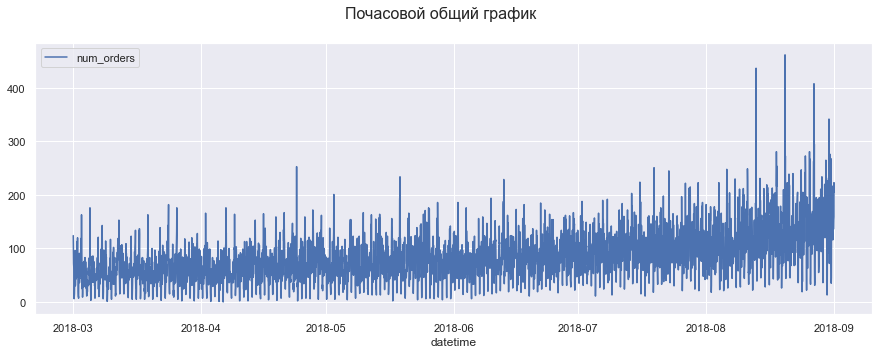

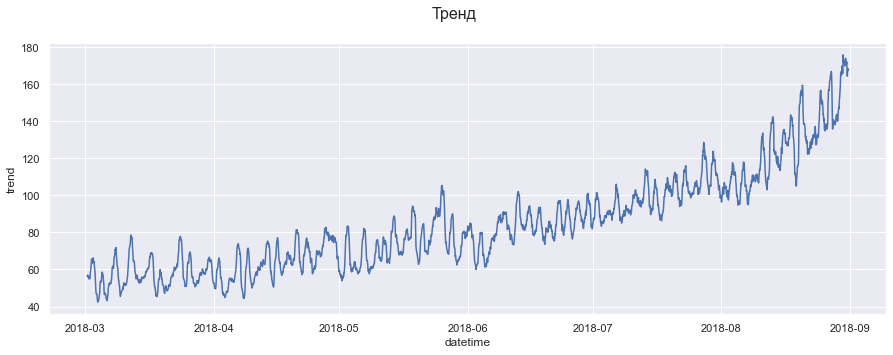

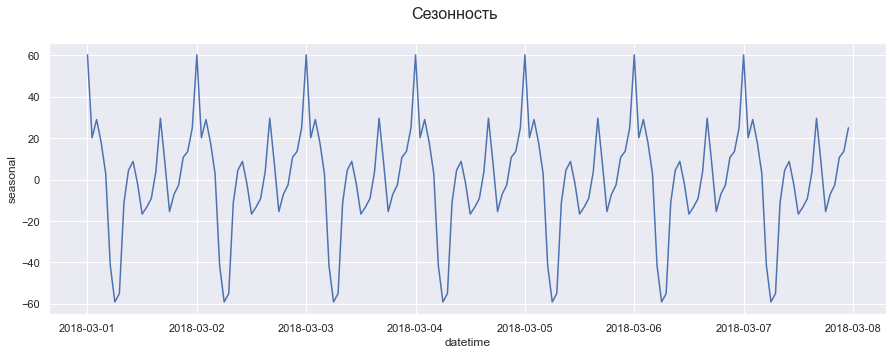

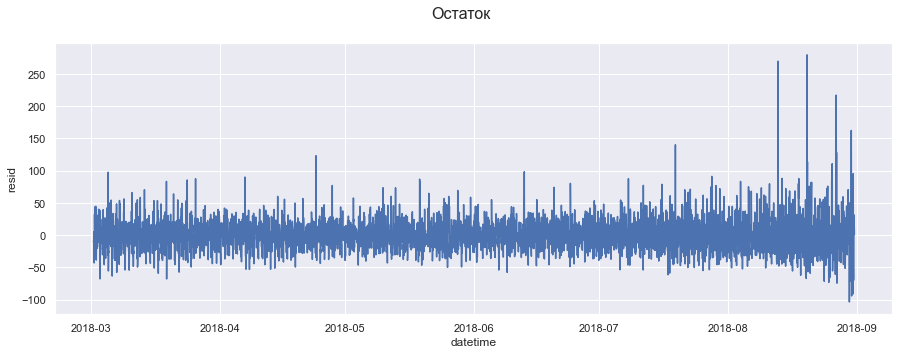

In [3]:
decomp_df = seasonal_decompose(df)

def decomp_viz(df, title=None):
    fig = plt.figure()
    sns.lineplot(data=df)
    fig.suptitle(title, fontsize=16)
    plt.show()
    
    return None

decomp_viz(df, title="Почасовой общий график")
decomp_viz(decomp_df.trend, "Тренд")
decomp_viz(decomp_df.seasonal.head(24*7), "Сезонность")
decomp_viz(decomp_df.resid, "Остаток")

На визуализации мы можем наблюдать растущий тренд заказов у агрегатора такси. Сложно сказать от чего зависит тренд роста заказов, временной период и предистория не позволяет это сделать.

На графике сезонности можно наблюдать сезонность заказов у агрегатора в пределах одной недели. График стационарный. Можно выделить, что ближе к час-пику количество заказов достигает максимального пика.

# Обучение

In [4]:
class FeaturesMaker(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag, rolling_mean_size, y):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.y = y
        
    def _reset(self):        
        if hasattr(self, "X_"):               
            del self.X_
            del self.y_
        
    def fit(self, X, y=None):
        self._reset()           
        self.X_ = X.drop(columns=self.y)
        self.y_ = X[self.y]
        
        return self
            
    def transform(self, X):

        temp = X.copy()
        
        for lag in range(self.max_lag):
            temp["lag_" + str(lag)] = temp[self.y].shift(lag+1)
            
        temp["rolling_mean"] = (temp[self.y]
                                .shift()
                                .rolling(self.rolling_mean_size)
                                .mean()
                               )
        
        temp["month"] = X.index.month
        temp["day"] = X.index.day
        temp["dayofweek"] = X.index.dayofweek
        temp["hour"] = X.index.hour
        for lag in  range(self.max_lag+1):
            temp.iloc[:lag+1, lag] = self.y_[-lag-1:].values.T
                
        temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \
        self.y_[-self.rolling_mean_size:].values.T
        
        temp = temp.drop(columns=self.y)

        return temp

In [5]:
maker = FeaturesMaker(max_lag=4, rolling_mean_size=1, y="num_orders")
maker.fit_transform(df)

<ipython-input-4-14a219b4c878>:39: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \


,lag_0,lag_1,lag_2,lag_3,rolling_mean,month,day,dayofweek,hour
datetime,,,,,,,,,
2018-03-01 00:00:00,223.0,159.0,154.0,136.0,205.0,3,1,3,0
2018-03-01 01:00:00,205.0,223.0,159.0,154.0,124.0,3,1,3,1
2018-03-01 02:00:00,85.0,205.0,223.0,159.0,85.0,3,1,3,2
2018-03-01 03:00:00,71.0,85.0,205.0,223.0,71.0,3,1,3,3
2018-03-01 04:00:00,66.0,71.0,85.0,205.0,66.0,3,1,3,4
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,207.0,217.0,197.0,116.0,207.0,8,31,4,19
2018-08-31 20:00:00,136.0,207.0,217.0,197.0,136.0,8,31,4,20
2018-08-31 21:00:00,154.0,136.0,207.0,217.0,154.0,8,31,4,21


In [6]:
X = df
y = df["num_orders"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                      test_size=.1, \
                                                      shuffle=False)

print("Целая выборка: {}\nОбучающая: {}\nТестовая: {}"
     .format(X.shape, X_train.shape, X_test.shape))

Целая выборка: (4416, 1)
Обучающая: (3974, 1)
Тестовая: (442, 1)


In [8]:
def rmse(y, predictions):
    """
    Возвращает расчёт RMSE
    y - целевой признак
    predictions - предсказания модели
    
    для расчёта RMSE использована функция 
    mean_squared_error(X, y) из библиотеки sklearn
    """
    return np.sqrt(mse(y, predictions))

rmse_score = make_scorer(rmse, greater_is_better=False)

In [9]:
cv = TimeSeriesSplit(n_splits=3)

pipe = Pipeline([
    ("maker", FeaturesMaker(max_lag=4, rolling_mean_size=1, y="num_orders")),
    ("model", LinearRegression())
])

params = [
    {
        "maker__max_lag": [12, 24, 36],
        "maker__rolling_mean_size": [1, 5, 10],
        "model": [LinearRegression()],
    }, {
        "maker__max_lag": [12, 24, 36],
        "maker__rolling_mean_size": [1, 5, 10],
        "model": [Lasso(random_state=42)],
        "model__alpha": np.logspace(-1, 2, 20),
    }, {
        "maker__max_lag": [12, 24, 36],
        "maker__rolling_mean_size": [1, 5, 10],
        "model": [RandomForestRegressor(random_state=42)],
        "model__criterion": ["mse"],
        "model__max_depth": [3, 6, 9],
        "model__n_estimators": [100, 150],
    }, {
        "maker__max_lag": [12, 24, 36],
        "maker__rolling_mean_size": [1, 5, 10],
        "model": [LGBMRegressor(boosting_type='gbdt', random_state=42)],
        "model__n_estimators": [100, 150],
        "model__num_leaves": [21, 31, 41],
    }
]

In [10]:
grid = GridSearchCV(estimator=pipe, param_grid=params, \
                    scoring=rmse_score, cv=cv, n_jobs=-1)

In [11]:
%%time
grid.fit(X_train, y_train)

<ipython-input-4-14a219b4c878>:39: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \


Wall time: 1min 35s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('maker',
                                        FeaturesMaker(max_lag=4,
                                                      rolling_mean_size=1,
                                                      y='num_orders')),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'maker__max_lag': [12, 24, 36],
                          'maker__rolling_mean_size': [1, 5, 10],
                          'model': [LinearRegression()]},
                         {'maker__max_lag': [12, 24, 36],
                          'maker__rolli...
                          'model': [RandomForestRegressor(random_state=42)],
                          'model__criterion': ['mse'],
                          'model__max_depth': [3, 6, 9],
                          'model__n_estimators': [100, 150]},
                         {'maker__max_lag':

In [12]:
display(grid.best_estimator_, grid.best_score_)

Pipeline(steps=[('maker',
                 FeaturesMaker(max_lag=12, rolling_mean_size=1,
                               y='num_orders')),
                ('model', LGBMRegressor(num_leaves=41, random_state=42))])

-26.149448494138237

Лучший результат по сетке показал LGBMRegressor, его мы и обучим на тестовой выборке

# Тестирование

In [13]:
model = grid.best_estimator_

model.fit(X_train, y_train)
rmse(model.predict(X_test), y_test)

<ipython-input-4-14a219b4c878>:39: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \


42.18450616981205

Требуемое качество метрики достигнуто